In [149]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

%matplotlib inline

### Pattern Matching Threshold Analysis

In [7]:
def pattern_matching(img, template, method, show_img = False):
    
    h, w = template.shape
    img2 = img.copy()

    result = cv2.matchTemplate(img2, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        location = min_loc
        score = min_val
    else:
        location = max_loc
        score = max_val
    
    if show_img:
        bottom_right = (location[0] + w, location[1] + h)    
        cv2.rectangle(img2, location, bottom_right, 255, 5)
        plt.imshow(img2)
        
    return img2, location, score

In [230]:
# Read in greyscale mode
img = cv2.imread('img/whole_img_2.png', 0)
img_o = cv2.imread('img/other_img.png', 0)
img_b = cv2.imread('img/whole_img_bn.png', 0)

template = cv2.imread('img/countdown.png', 0)
template_resized = cv2.resize(template, (0,0), fx = 0.5, fy = 0.5)

template_bn = cv2.imread('img/combat.png', 0)
template_bn_resized = cv2.resize(template_bn, (0,0), fx = 0.5, fy = 0.5)

methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
            cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

1.0

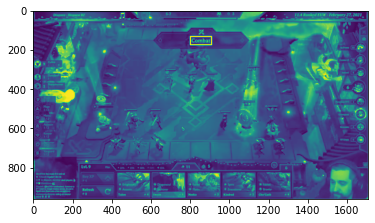

In [168]:
matched_img, location, score = pattern_matching(img_b, template_bn, methods[1], True)
score

0.8939361572265625

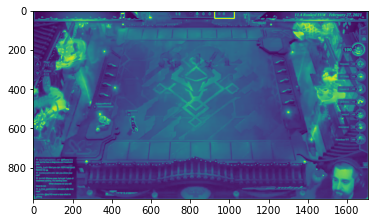

In [185]:
matched_img, location, score = pattern_matching(img, template, methods[1], True)
score

0.5489937663078308

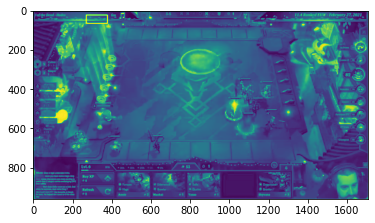

In [166]:
matched_img, location, score = pattern_matching(img_o, template, methods[1], True)
score

### Video Reading by Frames

Riot UI changed after April 15. 
*New* pattern matching technique needed.

In [255]:
cap = cv2.VideoCapture('contents/Big Bad Doggo - The Ultimate BIS Warwick  TFT Neon Nights  Teamfight Tactics.mp4')

In [256]:
# Get fps for frame skipping
fps = cap.get(cv2.CAP_PROP_FPS)

In [234]:
tic = time.perf_counter() # Time the code

count, skip_frames = 0, fps
combat_flag = False
combat_timestamp = 0
while cap.isOpened():
    ret,frame = cap.read()
    
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Match combat banner
        if not combat_flag:
            matched_img, location, score = pattern_matching(frame_gray, template_bn_resized, methods[1], False)
            if score > 0.90:
                combat_flag = True 
                combat_timestamp = count
                print(f"flag found at {combat_timestamp/fps} seconds")
        
        # Start looking for essential frame within 3s of founding the combat_timestamp
        elif combat_flag and count < combat_timestamp + fps * 10:
            matched_img, location, score = pattern_matching(frame_gray, template_resized, methods[1], False)
            if score > 0.88:
                cv2.imwrite("img/9/frame%d.jpg" % count, frame)
                combat_flag = False
                print(f"screen captured at {count/fps} seconds")
                count += fps * 9 # Forward 10s to avoid miss capturing 
        else:
            combat_flag = False # Reset the flag if out of bound

        count += skip_frames # This advances one second @ fps
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    else:
        cap.release()
        break
        
toc = time.perf_counter()
print(f"Finished the video in {toc - tic:0.4f} seconds")

flag found at 50.0 seconds
screen captured at 55.0 seconds
flag found at 99.0 seconds
screen captured at 103.0 seconds
flag found at 141.0 seconds
screen captured at 146.0 seconds
flag found at 193.0 seconds
screen captured at 198.0 seconds
flag found at 257.0 seconds
screen captured at 261.0 seconds
flag found at 321.0 seconds
screen captured at 326.0 seconds
flag found at 427.0 seconds
screen captured at 432.0 seconds
flag found at 506.0 seconds
screen captured at 510.0 seconds
flag found at 571.0 seconds
screen captured at 575.0 seconds
flag found at 630.0 seconds
screen captured at 634.0 seconds
flag found at 697.0 seconds
screen captured at 702.0 seconds
flag found at 771.0 seconds
screen captured at 776.0 seconds
flag found at 879.0 seconds
screen captured at 883.0 seconds
flag found at 953.0 seconds
screen captured at 958.0 seconds
flag found at 1008.0 seconds
screen captured at 1012.0 seconds
flag found at 1058.0 seconds
screen captured at 1063.0 seconds
flag found at 1124.0 se

### Frame Capturing based on combat flag only

In [257]:
cap = cv2.VideoCapture('contents/Big Bad Doggo - The Ultimate BIS Warwick  TFT Neon Nights  Teamfight Tactics.mp4')
fps = cap.get(cv2.CAP_PROP_FPS) 

In [ ]:
tic = time.perf_counter() # Time the code

count, skip_frames = 0, fps
combat_timestamp = 0
while cap.isOpened():
    ret,frame = cap.read()
    
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Match combat banner
        matched_img, location, score = pattern_matching(frame_gray, template_bn_resized, methods[1], False)
        if score > 0.90:
            print(f"flag found at {count/fps} seconds")
                
            cap.set(cv2.CAP_PROP_POS_FRAMES, count + 4.5*fps)
            _,frame = cap.read()
            cv2.imwrite("img/11/frame%d.jpg" % count, frame)
                
            count += skip_frames * 9 # Skip 10 skipframes 

        count += skip_frames # This advances one second @ fps
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    else:
        cap.release()
        break
        
toc = time.perf_counter()
print(f"Finished the video in {toc - tic:0.4f} seconds")

flag found at 27.0 seconds
flag found at 66.0 seconds
flag found at 128.0 seconds
flag found at 175.0 seconds
flag found at 236.0 seconds
flag found at 301.0 seconds
flag found at 408.0 seconds
flag found at 481.0 seconds
flag found at 535.0 seconds
flag found at 591.0 seconds
flag found at 667.0 seconds
flag found at 769.0 seconds
flag found at 883.0 seconds
flag found at 957.0 seconds
flag found at 1028.0 seconds
flag found at 1074.0 seconds
flag found at 1146.0 seconds
flag found at 1214.0 seconds
flag found at 1327.0 seconds
flag found at 1436.0 seconds
flag found at 1506.0 seconds
flag found at 1559.0 seconds


In [253]:
fps

30.0

### Problem Shooting

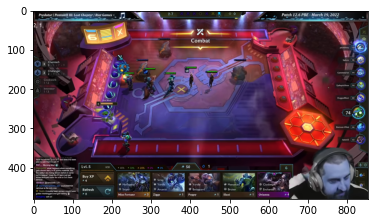

In [270]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 542.5 * fps)
ret,frame = cap.read()
plt.imshow(frame)

0.7968668937683105

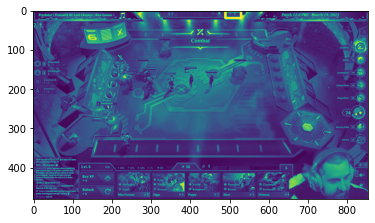

In [271]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
matched_img, location, score = pattern_matching(frame_gray, template_resized, methods[1], True)
score